In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from statsmodels.tsa.stattools import acf
import tensorflow as tf
import torch
from tensorflow.keras.models import load_model
from scipy.signal import find_peaks

In [2]:
# Load trained generator
generator = tf.keras.models.load_model("../saved_models/generator_91.keras")

In [ ]:
# Define your condition: [fc, amp]
condition = np.array([[0.35, 0.8]])  # shape (1, 3)

# Generate random latent noise
latent_dim = 100
z = np.random.normal(0, 1, (1, latent_dim))  # shape (1, 100)

# Pass inputs separately, not concatenated
generated_series = generator.predict([z, condition]) 

# Flatten to 1D for plotting or analysis
generated_series = generated_series[0].flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [4]:


def analyze_gan_generated_qpo(series, expected_fc=None, fs=1, label='GAN Output'):
    # Time array
    t = np.arange(0, len(series)) / fs

    # Fourier transform and power spectrum
    fft_vals = np.fft.rfft(series)
    freqs = np.fft.rfftfreq(len(series), 1/fs)
    power = (2.0 / len(series)) * np.abs(fft_vals)**2

    # Peak detection
    peaks, _ = find_peaks(power, height=np.mean(power) * 2)

    # Autocorrelation
    lag_values = np.arange(0, 200)
    acf_vals = acf(series, nlags=199, fft=True)

    # Plotting
    plt.figure(figsize=(12, 6))

    # PSD
    plt.subplot(2, 1, 1)
    plt.plot(freqs, power, label="Power Spectrum", color='darkblue')
    plt.scatter(freqs[peaks], power[peaks], color='red', label="Detected Peaks")
    if expected_fc:
        plt.axvline(expected_fc, linestyle='--', color='black', label=f"Expected QPO = {expected_fc:.2f} Hz")
    plt.xscale("log")
    plt.yscale("log")
    max_power = np.max(power)
    plt.ylim(max_power * 1e-4, max_power * 1.2)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.title(f"PSD of {label}")
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()

    # ACF
    plt.subplot(2, 1, 2)
    plt.plot(lag_values, acf_vals, color='green', label="Autocorrelation")
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.title("ACF")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print summary
    print("Detected QPO peaks (Hz):", freqs[peaks])
    if expected_fc:
        close_peaks = [f for f in freqs[peaks] if np.isclose(f, expected_fc, atol=0.02)]
        if close_peaks:
            print(f"✔ QPO detected near {expected_fc:.2f} Hz: {close_peaks}")
        else:
            print(f"✘ No peak detected near expected QPO frequency: {expected_fc:.2f} Hz")


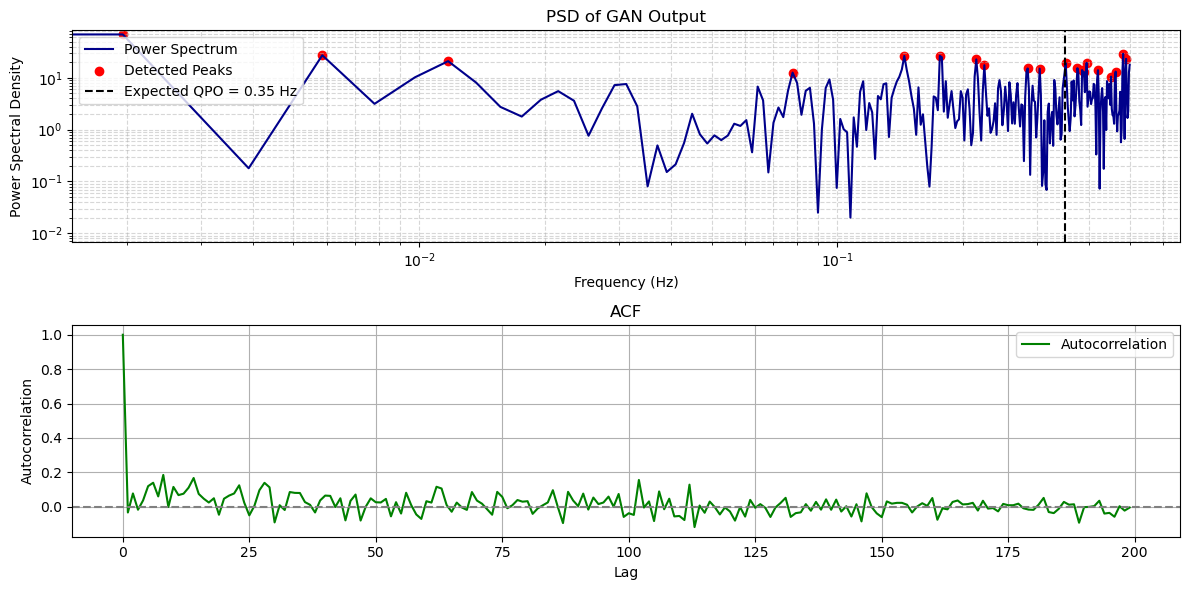

Detected QPO peaks (Hz): [0.00195312 0.00585938 0.01171875 0.078125   0.14453125 0.17578125
 0.21484375 0.22460938 0.28515625 0.3046875  0.3515625  0.375
 0.38476562 0.38867188 0.39453125 0.41992188 0.45117188 0.46289062
 0.48242188 0.49023438]
✔ QPO detected near 0.35 Hz: [0.3515625]


In [5]:
analyze_gan_generated_qpo(generated_series, expected_fc=0.35)
